<a href="https://colab.research.google.com/github/mahmoudta74/FIDVR/blob/main/FIDVR_Khorasan_Test5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard
%matplotlib inline
from IPython.display import display, clear_output
import pandas as pd
import time
import json

from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from tqdm.notebook import tqdm

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torch.optim as optim

torch.set_printoptions(linewidth=120) #Disply Option for output
torch.set_grad_enabled(True)          # already on by default\


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [5]:
!nvidia-smi

Tue Jun  8 08:13:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
print(torch.__version__)
print(torchvision.__version__)

1.8.1+cu101
0.9.1+cu101


In [8]:
# checking for GPU
torch.cuda.is_available()

True

In [37]:
df1 = pd.read_csv('/content/drive/MyDrive/dataset/Main_Dataset.csv')
df2 = pd.read_csv('/content/drive/MyDrive/dataset/result_rms1.csv')

data1 = df1.to_numpy()
data2 = df2.to_numpy()

In [38]:
train_data = data1[: , 160].reshape(-1, 1)
test_data  = data2[: , 160].reshape(-1, 1)

print(f'train_data size = {train_data.shape}\t test_data size = {test_data.shape}')

train_data size = (127051, 1)	 test_data size = (12130, 1)


In [11]:
def create_sequences(time, data, seq_length, num_run):
    xs = []
    ys = []
    t = time[0]
    j = 0

    for i in range(len(data) - (seq_length*num_run - num_run)):

        if t == 0:
            if j==0:
                x = data[j : (j + seq_length)]
                y = data[(j+ seq_length)]
                xs.append(x)
                ys.append(y)
                j = j+seq_length
                t = time[j]
            else:
                x = data[j+1 : (j+1 + seq_length)]
                y = data[(j+1+ seq_length)]
                xs.append(x)
                ys.append(y)
                j = j+seq_length
                t = time[j]


        else:
            x = data[j+1-seq_length : j+1]
            y = data[j+1]
            xs.append(x)
            ys.append(y)
            j = j+1
            t = time[j+1]

    return np.array(xs), np.array(ys)

In [39]:
seq_length = 35
time1 = data1[:,0]
time2 = data2[:,0]

X_train, y_train = create_sequences(time1, train_data, seq_length , num_run=1050)
X_test , y_test  = create_sequences(time2,  test_data , seq_length, num_run=105)

print(X_train.shape,'\t', y_train.shape)
print(X_test.shape,'\t', y_test.shape)

(91351, 35, 1) 	 (91351, 1)
(8560, 35, 1) 	 (8560, 1)


In [13]:
# You should build your custom dataset as below.
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, Data, target, Transform= None):
        self.data = Data
        self.label = target
        self.Transform = Transform
        
    def __getitem__(self, index):
        #r = self.data.iloc[index]
        label = torch.tensor(self.label[index], dtype= torch.float32)  
        sample = torch.tensor(self.data[index], dtype= torch.float32)
        if self.Transform:
            sample = self.Transform(sample)
        return (sample, label)

    def __len__(self):
        return self.data.shape[0]


In [14]:
from collections import OrderedDict
from collections import namedtuple
from itertools import product

In [15]:
class RunBuilder():
  @staticmethod       #Since the get_runs() method is static,
                      #we can call it using the class itself. We don't need an instance of the class.
  def get_runs(params):                

    Run = namedtuple('Run', params.keys()) #This line creates a new tuple subclass called Run that has named fields.
                                            # This Run class is used to encapsulate the data for each of our runs.
                                            # The field names of this class are set by the list of names passed to the 
                                            # constructor. First, we are passing the class name. Then,
                                            # we are passing the field names,
                                            # and in our case, we are passing the list of keys from our dictionary.

#Now that we have a class for our runs, we are ready to create some.
    runs = []
    for v in product(*params.values()):  #  v is a tuple like (0.01, 64, 'cuda')
      runs.append(Run(*v))               # *v is 
      
    return runs

In [16]:
class RunManager():
  
    def __init__(self):

        self.epoch_count = 0           # The number of epochs.
        self.epoch_loss = 0            # The running loss for an epoch.
        self.epoch_Val_loss = 0
        self.epoch_start_time = None   # The start time of the epoch.

        self.run_params = None         # This is the run definition in terms for the run parameters
        self.run_count = 0             # gives us the run number.
        self.run_start_time = None
        self.run_data = []             #  is a list we'll use to keep track of the parameter values and the
                                        # results of each epoch for each run and so we'll see that we
                                        # add a value to this list for each epoch

        self.network = None
        self.loader = None
        self.Val_loader = None
        self.tb = None

#######################################################

    def begin_run(self, run, network, loader, Val_loader):

        self.run_start_time = time.time()

        self.run_params = run
        self.run_count += 1

        self.network = network
        self.loader = loader
        self.Val_loader = Val_loader
        self.tb = SummaryWriter(comment=f'-{run}') # passing run as an comment argument to SummaryWriter

        data, labels = next(iter(self.loader))
        #grid = torchvision.utils.make_grid(images)

        #self.tb.add_image('images', grid)
        self.tb.add_graph(self.network, data.to(getattr(run, 'device', 'cpu')))

############################################################

    def end_run(self):
        self.tb.close()
        self.epoch_count = 0

########################################################3##3

    def begin_epoch(self):
        self.epoch_start_time = time.time()

        self.epoch_count += 1
        self.epoch_loss = 0
        self.epoch_Val_loss = 0

##############################################################3

    def end_epoch(self):

        epoch_duration = time.time() - self.epoch_start_time
        run_duration = time.time() - self.run_start_time

        loss = self.epoch_loss #/ len(self.loader.dataset)
        Val_loss = self.epoch_Val_loss #

        self.tb.add_scalar('Loss', loss, self.epoch_count)
        self.tb.add_scalar('Val_Loss', Val_loss, self.epoch_count)

        for name, param in self.network.named_parameters():
            self.tb.add_histogram(name, param, self.epoch_count)
            self.tb.add_histogram(f'{name}.grad', param.grad, self.epoch_count)


        results = OrderedDict()
        results["run"] = self.run_count
        results["epoch"] = self.epoch_count
        results['loss'] = loss
        results["Val_loss"] = Val_loss
        results['epoch duration'] = epoch_duration
        results['run duration'] = run_duration

        for k,v in self.run_params._asdict().items(): results[k] = v

        self.run_data.append(results)

        df = pd.DataFrame.from_dict(self.run_data, orient='columns')

        clear_output(wait=True)     # clear current output
        display(df)                 # display new dataframe

################################################################

    def track_loss(self, loss ,batch):
        self.epoch_loss += loss.item()

    def track_Val_loss(self, Val_loss ,batch):
        self.epoch_Val_loss += Val_loss.item()
    '''
    def track_num_correct(self, preds, labels):
        self.epoch_num_correct += self._get_num_correct(preds, labels)

##############################################################

    @torch.no_grad()
    def _get_num_correct(self, preds, labels): # private method
        return preds.argmax(dim=1).eq(labels).sum().item()
        '''
################################################################

    def save(self, fileName):       # save run data to .csv .json format

        pd.DataFrame.from_dict(
            self.run_data, orient='columns').to_csv(f'{fileName}.csv')

        with open(f'{fileName}.json', 'w', encoding='utf-8') as f:
            json.dump(self.run_data, f, ensure_ascii=False, indent=4)

###############################################################

In [17]:
class Network(nn.Module):

    def __init__(self, n_features, n_hidden, n_layers):
        super(Network, self).__init__()

        self.n_features = n_features
        self.n_hidden = n_hidden
        self.n_layers = n_layers

        self.lstm = nn.LSTM(input_size= n_features, hidden_size= n_hidden,
                             num_layers = n_layers, batch_first = True,
                             dropout = 0.3
                             )
            

        self.linear1 = nn.Linear(in_features= n_hidden, out_features= 5)
        self.linear2 = nn.Linear(in_features= 5, out_features= 1)

    def forward(self, x):

        h0 = torch.randn(self.n_layers, x.size(0), self.n_hidden).to('cuda')  # (batch_size= x.size(0) )
        c0 = torch.randn(self.n_layers, x.size(0), self.n_hidden).to('cuda')
        output, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.linear1(hn[0])
        out = self.linear2(out)

        return out

In [40]:
train_set = CustomDataset(X_train, y_train, Transform= None)
test_set = CustomDataset(X_test, y_test, Transform= None)

In [41]:
for layer in network.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()

In [42]:
params = OrderedDict(
    lr = [0.000012]
    ,batch_size = [128]
    , num_workers = [0]        #,1,2 ,...
    , device = ['cuda']
)

m = RunManager()

for run in RunBuilder.get_runs(params):

    device = torch.device(run.device)
    network = Network(n_features=1 , n_hidden=128 , n_layers=2).to(device)

    loader = DataLoader(train_set, batch_size = run.batch_size,
                                           num_workers = run.num_workers,
                                           drop_last=True,
                                           shuffle=False) 
    
    Val_loader = DataLoader(test_set, batch_size = run.batch_size,
                                           num_workers = run.num_workers,
                                           drop_last=True,
                                           shuffle=False) 
    
    optimizer = optim.Adam(params= network.parameters(), lr= run.lr)
    loss_fn = torch.nn.MSELoss()

    m.begin_run(run, network, loader, Val_loader)

    for epoch in range(200):
        m.begin_epoch()

        network.train()
        for batch in loader:
            data = batch[0].to(device)
            labels = batch[1].to(device)
            preds = network(data)
            loss = loss_fn(preds, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            m.track_loss(loss, batch)

        network.eval()
        with torch.no_grad():
            for batch in Val_loader:
                data = batch[0].to(device)
                labels = batch[1].to(device)
                preds = network(data)
                val_loss = loss_fn(preds, labels)

                m.track_Val_loss(val_loss, batch)

        m.end_epoch()
    m.end_run()
    
#m.save('results')

,run,epoch,loss,Val_loss,epoch duration,run duration,lr,batch_size,num_workers,device
0,1,1,637.098587,9.982454,7.760103,7.819700,0.000012,128,0,cuda
1,1,2,114.999563,7.667658,7.832330,15.785179,0.000012,128,0,cuda
2,1,3,77.745535,4.032227,7.700713,23.628120,0.000012,128,0,cuda
3,1,4,28.973164,1.366753,7.719661,31.486602,0.000012,128,0,cuda
4,1,5,12.975648,0.821335,7.719641,39.347172,0.000012,128,0,cuda
...,...,...,...,...,...,...,...,...,...,...
195,1,196,0.041506,0.004132,7.899637,1541.783829,0.000012,128,0,cuda
196,1,197,0.041291,0.004103,7.871723,1549.797556,0.000012,128,0,cuda
197,1,198,0.041160,0.004082,8.012267,1557.952713,0.000012,128,0,cuda
198,1,199,0.040856,0.004064,7.933094,1566.037757,0.000012,128,0,cuda


In [36]:
# Save and load the entire model
torch.save(network, '/content/drive/MyDrive/FIDVR_Models/model_sarayan3.ckpt')
#network = torch.load('model_asadabad3.ckpt')

# Save and load only the model parameters (recommended)
torch.save(network.state_dict(), '/content/drive/MyDrive/FIDVR_Models/params_sarayan3.ckpt')
#network.load_state_dict(torch.load('params.ckpt'))

In [ ]:
# Tensorboard
%load_ext tensorboard
%tensorboard  --logdir=runs

In [59]:
df = pd.read_csv('/content/drive/MyDrive/dataset/Oneshot_Test4.csv')
data = df.to_numpy()
t = data[:, 0]
data = data[:,160]   #158

In [60]:
tst = torch.tensor(data[0:35], dtype=torch.float32).reshape(1,35,1).to('cuda')

In [61]:
preds = []
network.eval()
with torch.no_grad():
    
    pred = network(tst)
    preds.append(pred.squeeze().item())
    #print(preds)

    for i in range(60):
        tst = torch.roll(tst, -1, 1)
        tst[0,34,0] = pred.squeeze().item()
        #print(tst)
        pred = network(tst)
        preds.append(pred.squeeze().item())

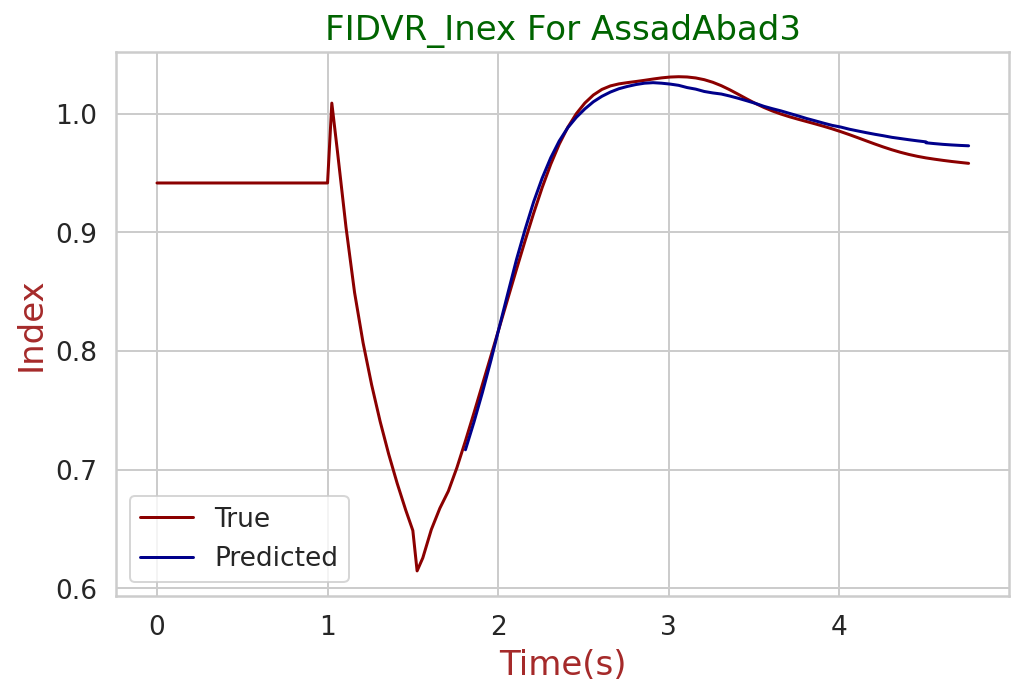

In [62]:
plt.figure(figsize=(8,5))
plt.plot(t[0:96], data[0:96], label='True', c='darkred')
plt.plot(t[35:96], preds, label='Predicted', c='darkblue')
plt.title('FIDVR_Inex For AssadAbad3', c='darkgreen', fontsize = 17)
plt.xlabel('Time(s)', fontsize = 17, c='brown')
plt.ylabel('Index', fontsize = 17, c='brown')
#plt.ylim((-1.5, 1.5))
plt.legend()
